Imports

In [1]:
import itertools
import random
import time

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import optutilities

The following code block generates data for a 10-location TSP instance and a scatterplot showing the orientation of locations.

In [2]:
tsp_data = optutilities.tsp.generate_random_tsp_data(
    n_locations=10,
    random_seed=42,
)

coordinates_df = tsp_data.get('coordinates_df')
locations = tsp_data.get('locations')
location_distances = tsp_data.get('location_distances')

The following code block plots the generated data.

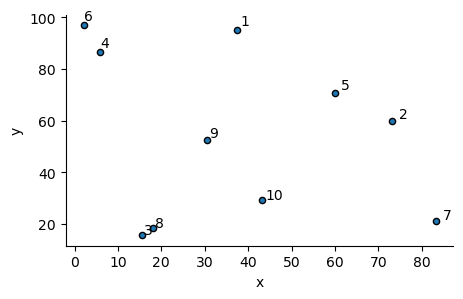

In [3]:
optutilities.tsp.generate_tsp_plot(
    coordinates_df,
    label_locations=True,
    figsize_tuple=(5, 3)
)

The following code block solves the TSP instance using Gurobi to get the optimal solution. **Note: You will need to have Gurobi installed and an active license to run this cell. If you don't have Gurobi installed, skip this cell.**

In [4]:
tsp_solve_data = optutilities.tsp.solve_tsp(
    locations=locations,
    distance_dict=location_distances,
)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-30
Set parameter TimeLimit to value 60
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 100 columns and 190 nonzeros
Model fingerprint: 0xe1b4602c
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 545.5926273
Presolve removed 10 rows and 10 columns
Presolve time: 0.00s
Presolved: 20 rows, 90 columns, 180 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)

Root relaxation: objective 2.290519e+02, 14 iterations, 0.00 seconds (0.00

The following code block plots the solution. **Note: This depends on the output of the previous cell. If you don't have Gurobi installed, skip this cell.**

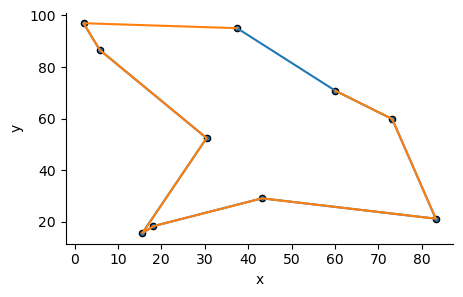

In [5]:
X = tsp_solve_data.get('X')

solution_tour = optutilities.tsp.convert_tsp_X_to_tour(
    locations=locations,
    X=X,
)

optutilities.tsp.generate_tsp_plot(
    coordinates_df=coordinates_df,
    tour_list=solution_tour,
    label_locations=False,
    figsize_tuple=(5, 3)
)

#### Genetic Algorithm

The following code block defines a function we will use to plot the progress of our genetic algorithm.

In [6]:
def get_improvement_plot(
    progress_dict: dict,
    figsize_tuple: tuple = (6, 4),
    logx: bool = True,
    title: str = '',
) -> None:

    import matplotlib.pyplot as plt
    import pandas as pd

    fig, ax = plt.subplots(1, 1, figsize=figsize_tuple)

    pd.DataFrame.from_dict(
        progress_dict,
        orient='index',
        columns=['value']
    ).reset_index().rename(
        columns={'index': 'iteration'}
    ).plot(
        x='iteration',
        y='value',
        logx=logx,
        ax=ax,
        legend=False,
    )

    ax.spines[['right', 'top']].set_visible(False)
    ax.axhline(
        min(progress_dict.values()),
        color='k',
        linestyle='--',
    )

    if title:
        ax.set_title(title)

The following code block defines a function to compute the distance of a tour, which will correspond to the *fitness* of solutions in our genetic algorithm implementation.

In [7]:
def GA_TSP_compute_fitness(
    tour_list: list,
    distance_dict: dict,
) -> float:

    distance = 0
    for stop_idx, stop in enumerate(tour_list[:-1]):
        distance += distance_dict[stop, tour_list[stop_idx+1]]
    distance += distance_dict[tour_list[-1], tour_list[0]]

    return distance

The following code block defines a function that performs the mating/crossover/mutation of two *parent* tours to create a *child* tour.

In [8]:
def GA_TSP_crossover(
    parent1: list,
    parent2: list,
) -> list:

    crossover = np.random.randint(
        low=1, 
        high=len(parent1)-2,
    )
    
    mutated = parent1[:crossover+1]
    mutated += [val for val in parent2 if val not in mutated]
    
    return mutated

The following code block demonstrates the previous function.

In [9]:
parent1 = locations
parent2 = locations[::-1]

print(f'Parent 1: {parent1}')
print(f'Parent 2: {parent2}')
np.random.seed(0)
for i in range(1, 10):
    child = GA_TSP_crossover(parent1, parent2)
    print(f'Child {i:>2}: {child}')

Parent 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Parent 2: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Child  1: [1, 2, 3, 4, 5, 6, 10, 9, 8, 7]
Child  2: [1, 2, 3, 4, 5, 6, 7, 10, 9, 8]
Child  3: [1, 2, 10, 9, 8, 7, 6, 5, 4, 3]
Child  4: [1, 2, 3, 4, 5, 10, 9, 8, 7, 6]
Child  5: [1, 2, 3, 4, 5, 10, 9, 8, 7, 6]
Child  6: [1, 2, 3, 4, 5, 10, 9, 8, 7, 6]
Child  7: [1, 2, 3, 10, 9, 8, 7, 6, 5, 4]
Child  8: [1, 2, 3, 4, 5, 10, 9, 8, 7, 6]
Child  9: [1, 2, 3, 4, 5, 6, 7, 10, 9, 8]


The following code block defines a function to generate an initial population for the genetic algorithm.

In [10]:
def GA_TSP_generate_initial_population(
    locations_list: list,
    population_size: int,
    distance_dict: dict,
    random_seed: int | None = None,
) -> dict:
    import numpy as np
    
    population_dict = {}
    if isinstance(random_seed, int):
        np.random.seed(random_seed)
        
    for idx in range(1, population_size+1):
        tour = np.random.choice(
            locations_list, 
            replace=False, 
            size=len(locations_list),
        )
        population_dict[f'P{idx}'] = {
            'tour': list(tour),
            'fitness': GA_TSP_compute_fitness(
                tour_list=tour,
                distance_dict=distance_dict,
            )
        }
        
    return population_dict

The following code block demonstrates the previous function.

In [11]:
initial_population = GA_TSP_generate_initial_population(
    locations, 
    population_size=5,
    distance_dict=location_distances,
)

initial_population

{'P1': {'tour': [4, 2, 10, 9, 6, 1, 7, 8, 5, 3], 'fitness': 592.0914671868317},
 'P2': {'tour': [6, 3, 4, 5, 2, 1, 10, 9, 8, 7], 'fitness': 583.2350824182821},
 'P3': {'tour': [6, 2, 10, 3, 7, 8, 1, 4, 5, 9], 'fitness': 543.0380075211007},
 'P4': {'tour': [6, 3, 8, 5, 2, 1, 7, 9, 10, 4], 'fitness': 475.1470992681132},
 'P5': {'tour': [2, 9, 10, 6, 3, 7, 4, 8, 5, 1], 'fitness': 621.0430808434296}}

The following code block defines a function that can be used to sort a population by fitness, from smallest to largest value. Note that it expects the population passed in the `entities_dict` argument to match the format returned by the `GA_TSP_generate_initial_population` function.

In [12]:
def GA_TSP_sort_entities_by_fitness(
    entities_dict: dict,
) -> dict:
    
    sorted_fitness_tuples = sorted(
        entities_dict.items(), 
        key=lambda x: x[1]['fitness'],
    )
    sorted_fitness_dict = {key: val for key, val in sorted_fitness_tuples}

    return sorted_fitness_dict

The following code block demonstrates the previous function.

In [13]:
GA_TSP_sort_entities_by_fitness(initial_population)

{'P4': {'tour': [6, 3, 8, 5, 2, 1, 7, 9, 10, 4], 'fitness': 475.1470992681132},
 'P3': {'tour': [6, 2, 10, 3, 7, 8, 1, 4, 5, 9], 'fitness': 543.0380075211007},
 'P2': {'tour': [6, 3, 4, 5, 2, 1, 10, 9, 8, 7], 'fitness': 583.2350824182821},
 'P1': {'tour': [4, 2, 10, 9, 6, 1, 7, 8, 5, 3], 'fitness': 592.0914671868317},
 'P5': {'tour': [2, 9, 10, 6, 3, 7, 4, 8, 5, 1], 'fitness': 621.0430808434296}}

A function to randomly select pairs of entities from a population for mating follows.

In [14]:
def GA_TSP_randomly_select_mates(
    population_dict: dict,
    children_to_generate: int,
) -> list:
    import numpy as np
    
    possible_mates = itertools.product(
        population_dict.keys(),
        population_dict.keys(),
    )
    possible_mates = list(possible_mates)
    possible_mates = [(mate1, mate2) for (mate1, mate2) in possible_mates if mate1 != mate2]

    replace = False
    if children_to_generate > len(possible_mates):
        print('children_to_generate > number of possible mates. Mates will contain duplicates.')
        replace = True
        
    mating_indices = np.random.choice(
        a=range(0, len(possible_mates)),
        size=children_to_generate,
        replace=replace,
    ).tolist()

    mate_list = []
    for mating_idx in mating_indices:
        parent1_name, parent2_name = possible_mates[mating_idx]
        mate_list.append([parent1_name, parent2_name])

    return mate_list

The function is demonstrated in the following code block.

In [15]:
mates = GA_TSP_randomly_select_mates(
    population_dict=initial_population, 
    children_to_generate=10,
)

mates

[['P5', 'P1'],
 ['P5', 'P3'],
 ['P3', 'P5'],
 ['P1', 'P4'],
 ['P1', 'P5'],
 ['P4', 'P5'],
 ['P2', 'P5'],
 ['P3', 'P4'],
 ['P4', 'P1'],
 ['P4', 'P3']]

The function defined in the following code block performs the mating/crossover/mutation of parent solutions to generate children. Note that the function is designed to allow a simple neighborhood search on produced children solutions to introduce additional variability.

In [16]:
def GA_TSP_perform_mating(
    population_dict: dict,
    mates_list: list,
    distance_dict: dict,
    mutation_function = None,
    mutation_iterations: int = 10,
):
    children_dict = {}
    for parent1_name, parent2_name in mates_list:
        child_tour = GA_TSP_crossover(
            parent1=population_dict[parent1_name]['tour'], 
            parent2=population_dict[parent2_name]['tour'],
        )
        child_fitness = GA_TSP_compute_fitness(
            tour_list=child_tour,
            distance_dict=distance_dict,
        )
        if mutation_function:
            best_tour = list(child_tour)
            best_fitness = child_fitness
            for i in range(mutation_iterations):
                mutated_tour = mutation_function(best_tour)
                mutated_tour_fitness = GA_TSP_compute_fitness(
                    tour_list=mutated_tour,
                    distance_dict=distance_dict,
                )
                if mutated_tour_fitness < best_fitness:
                    best_tour = list(mutated_tour)
                    best_fitness = mutated_tour_fitness
            child_tour = list(best_tour)
            child_fitness = best_fitness
                
        children_dict[f'C-{parent1_name}x{parent2_name}'] = {
            'tour': child_tour,
            'fitness': child_fitness,
        }

    return children_dict

The following code block demonstrates the function.

In [17]:
children = GA_TSP_perform_mating(
    population_dict=initial_population,
    mates_list=mates,
    distance_dict=location_distances,
    mutation_function=optutilities.improvement.apply_three_opt
)

children

{'C-P5xP1': {'tour': [2, 9, 8, 10, 4, 3, 6, 1, 7, 5],
  'fitness': 523.7868553277128},
 'C-P5xP3': {'tour': [2, 9, 6, 10, 7, 8, 3, 4, 1, 5],
  'fitness': 439.96789699277565},
 'C-P3xP5': {'tour': [6, 4, 10, 8, 3, 7, 5, 9, 1, 2],
  'fitness': 441.67459357542106},
 'C-P1xP4': {'tour': [4, 2, 10, 9, 7, 3, 8, 5, 1, 6],
  'fitness': 421.9289636205762},
 'C-P1xP5': {'tour': [4, 9, 2, 1, 10, 7, 3, 8, 5, 6],
  'fitness': 456.20698624585395},
 'C-P4xP5': {'tour': [6, 3, 8, 5, 2, 1, 9, 10, 7, 4],
  'fitness': 443.6538352808974},
 'C-P2xP5': {'tour': [6, 2, 4, 1, 5, 8, 3, 7, 10, 9],
  'fitness': 477.72971758143717},
 'C-P3xP4': {'tour': [6, 2, 10, 3, 8, 5, 1, 7, 9, 4],
  'fitness': 459.42949448202415},
 'C-P4xP1': {'tour': [6, 5, 2, 1, 4, 10, 8, 3, 7, 9],
  'fitness': 445.2824890396158},
 'C-P4xP3': {'tour': [6, 3, 8, 10, 7, 1, 4, 9, 5, 2],
  'fitness': 448.25639882320155}}

Finally, the following code block defines a function to select children. Note that it contains an argument named `diverse_solution_proportion` that enables you to select a portion of children randomly, instead of solely using fitness. The number of diverse children to return is computed using the ceiling function. Thus, if you set this paramter to any value greater than zero, at least one of the selected children will be based on random selection.

In [18]:
def GA_TSP_select_children(
    entities_dict: dict,
    population_size: int,
    diverse_solution_proportion: float = 0.00,
) -> dict:

    import numpy as np
    
    diverse_solutions = int(np.ceil(population_size*diverse_solution_proportion))
    fittest_solutions = population_size - diverse_solutions
    
    sorted_children_dict = GA_TSP_sort_entities_by_fitness(children)
    fittest_children = list(sorted_children_dict.keys())[:fittest_solutions]
    
    remaining_children = set(sorted_children_dict.keys()) - set(fittest_children)
    
    diverse_children = np.random.choice(
        a=list(remaining_children),
        size=diverse_solutions,
        replace=False,
    ).tolist()
    
    selected_children = {}
    for child in fittest_children + diverse_children:
        selected_children[child] = entities_dict[child]

    return selected_children

The following code block demonstrates the use of the previously defined function.

In [19]:
selected_children = GA_TSP_select_children(
    entities_dict=children,
    population_size=5,
    diverse_solution_proportion=0.1,
)

selected_children

{'C-P1xP4': {'tour': [4, 2, 10, 9, 7, 3, 8, 5, 1, 6],
  'fitness': 421.9289636205762},
 'C-P5xP3': {'tour': [2, 9, 6, 10, 7, 8, 3, 4, 1, 5],
  'fitness': 439.96789699277565},
 'C-P3xP5': {'tour': [6, 4, 10, 8, 3, 7, 5, 9, 1, 2],
  'fitness': 441.67459357542106},
 'C-P4xP5': {'tour': [6, 3, 8, 5, 2, 1, 9, 10, 7, 4],
  'fitness': 443.6538352808974},
 'C-P3xP4': {'tour': [6, 2, 10, 3, 8, 5, 1, 7, 9, 4],
  'fitness': 459.42949448202415}}

#### Complete implementation

The following code block combines the previously defined functions into a complete implementation of a Genetic Algorithm with:
- 10 generations
- a population size of 50
- 200 children generated from each generation,
- no neighborhood search performed on children, and
- no diverse children kept at each generation.

For completeness, the code to generate data is included and we use a 50-location instance.

Running Genetic Algorithm:   0%|          | 0/10 [00:00<?, ?it/s]

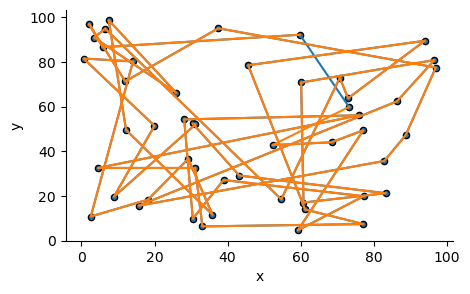

 - incumbent_fitness = 1826.37


In [20]:
n_locations = 50
population_size = 100
children_to_generate = 200
diverse_solution_proportion = 0.0
generations = 10
mutation_function = None
mutation_iterations = 100

tsp_data = optutilities.tsp.generate_random_tsp_data(
    n_locations=50,
    random_seed=42,
)

coordinates_df = tsp_data.get('coordinates_df')
locations = tsp_data.get('locations')
location_distances = tsp_data.get('location_distances')

population = GA_TSP_generate_initial_population(
    locations, 
    population_size=population_size,
    distance_dict=location_distances,
)

sorted_population = GA_TSP_sort_entities_by_fitness(
    population,
)
first_key = list(sorted_population.keys())[0]
incumbent = population[first_key]['tour']
incumbent_fitness = population[first_key]['fitness']

for generation in tqdm(range(generations), 'Running Genetic Algorithm'):
    mates = GA_TSP_randomly_select_mates(
        population_dict=population, 
        children_to_generate=children_to_generate,
    )

    children = GA_TSP_perform_mating(
        population_dict=population,
        mates_list=mates,
        distance_dict=location_distances,
        mutation_function=mutation_function,
        mutation_iterations=mutation_iterations,
    )

    children = GA_TSP_select_children(
        entities_dict=children,
        population_size=population_size,
        diverse_solution_proportion=diverse_solution_proportion,
    )
    
    sorted_children = GA_TSP_sort_entities_by_fitness(
        children,
    )
    first_key = list(sorted_children.keys())[0]
    best_child_fitness = children[first_key]['fitness']
    if best_child_fitness < incumbent_fitness:
        incumbent = children[first_key]['tour']
        incumbent_fitness = children[first_key]['fitness']

    population = {f'P{idx}': val for idx, (key, val) in enumerate(children.items(), 1)}

optutilities.tsp.generate_tsp_plot(
    coordinates_df=coordinates_df,
    tour_list=incumbent,
    label_locations=False,
    figsize_tuple=(5, 3)
)
print(f' - {incumbent_fitness = :.2f}')

The following code block combines the previously defined functions into a complete implementation of a Genetic Algorithm with:
- 100 generations
- a population size of 100
- 200 children generated from each generation,
- a 50-iteration 3-opt search applied to each child, and
- 10% of children selected randomly.

For completeness, the code to generate data is included and we use a 50-location instance.

Running Genetic Algorithm:   0%|          | 0/100 [00:00<?, ?it/s]

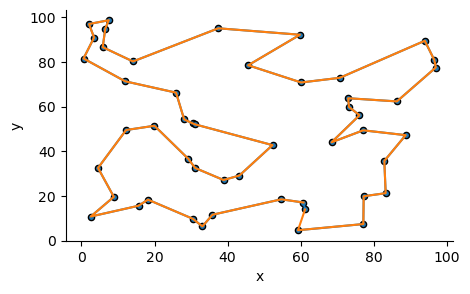

 - incumbent_fitness = 578.16


In [21]:
n_locations = 50
population_size = 100
children_to_generate = 200
diverse_solution_proportion = 0.10
generations = 100
mutation_function = optutilities.improvement.apply_three_opt
mutation_iterations = 50

tsp_data = optutilities.tsp.generate_random_tsp_data(
    n_locations=50,
    random_seed=42,
)

coordinates_df = tsp_data.get('coordinates_df')
locations = tsp_data.get('locations')
location_distances = tsp_data.get('location_distances')

population = GA_TSP_generate_initial_population(
    locations, 
    population_size=population_size,
    distance_dict=location_distances,
)

sorted_population = GA_TSP_sort_entities_by_fitness(
    population,
)
first_key = list(sorted_population.keys())[0]
incumbent = population[first_key]['tour']
incumbent_fitness = population[first_key]['fitness']

for generation in tqdm(range(generations), 'Running Genetic Algorithm'):
    mates = GA_TSP_randomly_select_mates(
        population_dict=population, 
        children_to_generate=children_to_generate,
    )

    children = GA_TSP_perform_mating(
        population_dict=population,
        mates_list=mates,
        distance_dict=location_distances,
        mutation_function=mutation_function,
        mutation_iterations=mutation_iterations,
    )

    children = GA_TSP_select_children(
        entities_dict=children,
        population_size=population_size,
        diverse_solution_proportion=diverse_solution_proportion,
    )
    
    sorted_children = GA_TSP_sort_entities_by_fitness(
        children,
    )
    first_key = list(sorted_children.keys())[0]
    best_child_fitness = children[first_key]['fitness']
    if best_child_fitness < incumbent_fitness:
        incumbent = children[first_key]['tour']
        incumbent_fitness = children[first_key]['fitness']

    population = {f'P{idx}': val for idx, (key, val) in enumerate(children.items(), 1)}

optutilities.tsp.generate_tsp_plot(
    coordinates_df=coordinates_df,
    tour_list=incumbent,
    label_locations=False,
    figsize_tuple=(5, 3)
)
print(f' - {incumbent_fitness = :.2f}')

The following code block solves the TSP instance using Gurobi to get the optimal solution. **Note: You will need to have Gurobi installed and an active license to run this cell. If you don't have Gurobi installed, skip this cell.**

Set parameter TimeLimit to value 60
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 150 rows, 2500 columns and 4950 nonzeros
Model fingerprint: 0xaeb3523f
Variable types: 0 continuous, 2500 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-07, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2922.7442354
Presolve removed 50 rows and 50 columns
Presolve time: 0.01s
Presolved: 100 rows, 2450 columns, 4900 nonzeros
Variable types: 0 continuous, 2450 integer (2450 binary)

Root relaxation: objective 4.565934e+02, 86 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |

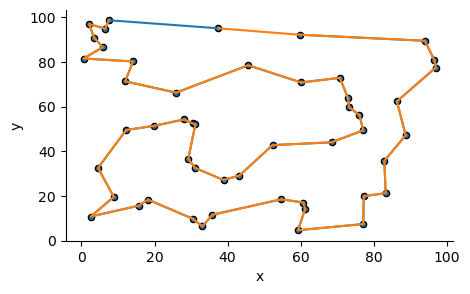

In [22]:
tsp_solve_data = optutilities.tsp.solve_tsp(
    locations=locations,
    distance_dict=location_distances,
)

X = tsp_solve_data.get('X')

solution_tour = optutilities.tsp.convert_tsp_X_to_tour(
    locations=locations,
    X=X,
)

optutilities.tsp.generate_tsp_plot(
    coordinates_df=coordinates_df,
    tour_list=solution_tour,
    label_locations=False,
    figsize_tuple=(5, 3)
)